In [267]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=1000)

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
# Define global var
list_dev = []
num_neg_jac_init = []
num_neg_jac = []
time_taken = []
full_start = time.time()

## Iterative SLSQP

In [269]:
# define helper functions

def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

# Define the objective function
def objective(phi, phi_init, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the objective function
def objective2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def objective3(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init)

def objectiveManh2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1) + np.linalg.norm(A_ @ phi - b_)

def objectiveManh(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1)


def nearest_center(shape, n):
    near_cent = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                z_cent = z
                y_cent = y
                x_cent = x
                if (x-n < 0):
                    x_cent = n
                elif (shape[2]-x < n+1):
                    x_cent = shape[2]-n-1

                if (y-n < 0):
                    y_cent = n
                elif (shape[1]-y < n+1):
                    y_cent = shape[1]-n-1
                center_indices = [z, y_cent, x_cent]
                near_cent[l_idx] = center_indices
                # print("Nearest center values for index ", l_idx, center_indices)
    return near_cent

def original_coordinates(shape):
    ori_coord = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                ori_coord[z * shape[1] * shape[2] + y * shape[2] + x] = (z,y,x)
    return ori_coord


def get_phi_sub_flat(phi, cz, cy, cx, shape, d):
    phix = phi[1, cy-d:cy+d+1, cx-d:cx+d+1]
    phiy = phi[0, cy-d:cy+d+1, cx-d:cx+d+1]
    # print(f'phi sub flat shapes are {phix.shape, phiy.shape, phi[1].shape, phi[0].shape} with limits being {cx-d}, {cx+d+1}, {cy-d}, {cy+d+1}')
    return np.concatenate([phix.flatten(), phiy.flatten()])


In [270]:
# jacobian functions

def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:])    )
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

def jdet_constraint2(phi_sub, phi, idx_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, ori_shape, epsilon=1e-6):
    start = time.time()
    dist = submatrix_size//2
    pixels = submatrix_size*submatrix_size
    phi[1, cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[:pixels].reshape((submatrix_size, submatrix_size))
    phi[0, cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[pixels:].reshape((submatrix_size, submatrix_size))

    phi = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    z,y,x = sub_ori_coord[idx_sub]
    z = z
    y = y+cy-dist
    x = x+cx-dist 

    idx = laplacian.get_laplacian_index(z,y,x, ori_shape)


    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
    
    end = time.time()
    # print(f'Jdet computed in {end-start}s')
    # print(f'jdet2 for {z,y,x} - {dxx, dyy, dxy, dyx}')
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

def jdet_constraint3(phi, cx, cy, cz, submatrix_size, ori_shape, epsilon=1e-6):
    constraints = []
    dist = submatrix_size//2
    for zi in range(1):
        for yi in range(cy-dist, cy+dist+1):
            for xi in range(cx-dist, cx+dist+1):
                constraints += [{'type': 'ineq', 'fun': lambda phi1: compute_jdet_for_pixel(phi1, phi, dist, zi, yi, xi, cz, cy, cx, submatrix_size, ori_shape, epsilon)}]

    return constraints


def compute_jdet_for_pixel(phi1, phi, dist, zi, yi, xi, cz, cy, cx, submatrix_size, ori_shape, epsilon=1e-6):
    # see if there is a way out of reshaping the submatrix too
    
    start = time.time()
    pixels = submatrix_size*submatrix_size
    phi_sub = np.zeros((2, submatrix_size, submatrix_size))
    phi_sub[1] = phi1[:pixels].reshape((submatrix_size, submatrix_size))
    phi_sub[0] = phi1[pixels:].reshape((submatrix_size, submatrix_size))
    
    left = xi-1
    right = xi+1
    top = yi-1
    bottom = yi+1
    
    xi_sub = xi-cx+dist
    left_sub = left-cx+dist
    right_sub = right-cx+dist

    yi_sub = yi-cy+dist
    top_sub = top-cy+dist
    bottom_sub = bottom-cy+dist

    # print(f'boundaries: {cx-dist, left, right, cx+dist, ori_shape[-1], cy-dist, top, bottom, cy+dist, ori_shape[-2]}')
    if left < cx-dist: # left edge of sub
        if left < 0: # leftmost edge
            dxx = (phi_sub[1, yi_sub, right_sub] - phi_sub[1, yi_sub, xi_sub]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi_sub[0, yi_sub, xi_sub]) / 2
        else:
            dxx = (phi_sub[1, yi_sub, right_sub] - phi[1, yi, left]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi[0, yi, left]) / 2
    else:
        if right > cx+dist: # right edge of sub
            if right > ori_shape[-1]-1: # rightmost edge
                dxx = (phi_sub[1, yi_sub, xi_sub] - phi_sub[1, yi_sub, left_sub]) / 2
                dyx = (phi_sub[0, yi_sub, xi_sub] - phi_sub[0, yi_sub, left_sub]) / 2
            else:
                # print(f'{yi, right, left_sub}')
                dxx = (phi[1, yi, right] - phi_sub[1, yi_sub, left_sub]) / 2
                dyx = (phi[0, yi, right] - phi_sub[0, yi_sub, left_sub]) / 2
        else: # inside the submatrix
            dxx = (phi_sub[1, yi_sub, right_sub] - phi_sub[1, yi_sub, left_sub]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi_sub[0, yi_sub, left_sub]) / 2

    if top < cy-dist: # top edge of sub
        if top < 0: # topmost edge
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi_sub[1, yi_sub, xi_sub]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi_sub[0, yi_sub, xi_sub]) / 2
        else:
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi[1, top, xi]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi[0, top, xi]) / 2
    else:
        if bottom > cy+dist: # bottom edge of sub
            if bottom > ori_shape[-2]-1: # bottom most edge
                dxy = (phi_sub[1, yi_sub, xi_sub] - phi_sub[1, top_sub, xi_sub]) / 2
                dyy = (phi_sub[0, yi_sub, xi_sub] - phi_sub[0, top_sub, xi_sub]) / 2
            else:
                dxy = (phi[1, bottom, xi] - phi_sub[1, top_sub, xi_sub]) / 2
                dyy = (phi[0, bottom, xi] - phi_sub[0, top_sub, xi_sub]) / 2
        else: # inside the submatrix
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi_sub[1, top_sub, xi_sub]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi_sub[0, top_sub, xi_sub]) / 2
    end = time.time()

    # print(f'Jdet3 computed in {end-start}s')
    # print(f'jdet3 for {zi, yi_sub, xi_sub} - - {dxx, dyy, dxy, dyx}')
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

                

In [271]:
def jacobian_constraint(phi_xy, submatrix_size):
    deformation = np.zeros((3,1, submatrix_size, submatrix_size))
    pixels = submatrix_size*submatrix_size
    deformation[2] = phi_xy[:pixels].reshape((submatrix_size, submatrix_size))
    deformation[1] = phi_xy[pixels:].reshape((submatrix_size, submatrix_size))
    return jacobian.sitk_jacobian_determinant(deformation).flatten()

In [ ]:
def iterative_with_jacobians(deformation_i, methodName='SLSQP'):
    '''perform SLSQP on submatrices iteratively'''
    slice_shape = (1, *deformation_i.shape[-2:])

    # this phi will be updated iteratively
    phi = np.zeros((2, *deformation_i.shape[-2:]))
    phi[1] = deformation_i[-1]
    phi[0] = deformation_i[-2]
    print(f'deformation_i shape: {deformation_i.shape}, phi_init shape: {phi.shape}')
    phi_init = phi.copy()

    # set threshold for Jacobian and store results
    threshold = 0.0
    jacobians = []
    indi_times = []
    tot_start = time.time()

    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi)
    jacobians.append(J_init)
    J_init = J_init.flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])].tolist()
    print(f'init: Negative Jacobians found at {neg_jacobian_indices}')

    # set values to use inside the while loop
    idx_adj = idx_adjacency(slice_shape)
    y_offset = len(J_init)//2
    # find the nearest center of a 5x5 matrix around each pixel
    submatrix_size = 5
    near_cent = nearest_center(slice_shape, submatrix_size//2)
    ori_coord = original_coordinates(slice_shape)


    sub_shape = (1,submatrix_size, submatrix_size)
    sub_ori_coord = original_coordinates(sub_shape)
    _, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3)))

    visited = {}
    max_visits = 3
    ind = 0

    
    # perform optimisation for each index with negative Jacobian
    while ind < len(neg_jacobian_indices) and ind < 50:
        neg_index  = neg_jacobian_indices[ind]
        ind += 1
        # if the negative values has already been fixed, skip it
        jdet_value = jacobian_det2D(phi).flatten()[neg_index]
        if (jdet_value > threshold):
            print(f'Iter {ind}: jacobian at index {neg_index} is +ve. skip.')
            continue

        # check number of visits to this index and increase submatrix size if necessary
        visits = visited.get(neg_index, 0) + 1
        visited[neg_index] = visits

        # increase submatrix size if not sufficient
        if (visits > max_visits and submatrix_size + 2 <= min(slice_shape[1:])):
            # increase subshape and everything that depends on it
            submatrix_size+=2
            max_visits += 1
            print(f'Submatrix size is {submatrix_size} from index {neg_index}')
            near_cent = nearest_center(slice_shape, submatrix_size//2)
            ori_coord = original_coordinates(slice_shape)
            sub_shape = (1,submatrix_size, submatrix_size)
            sub_ori_coord = original_coordinates(sub_shape)
            _, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3)))
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Iter {ind}: Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}, jdet: {jdet_value}')

        # get constraints for optimisation
        # constraints = []
        # for i_sub in range(len(b_sub)//2):
        #     constraints += [{'type': 'ineq', 'fun': lambda phi1, i=i_sub: jdet_constraint2(phi1, phi.copy(), i, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, slice_shape, 0.05)}]
        
        # no substitution of submatrix inside bigger one
        constraints = jdet_constraint3(phi, cx, cy, cz, submatrix_size, slice_shape, 0.05)

        op_start = time.time()

        phi_init_sub_flat = get_phi_sub_flat(phi_init, cz, cy, cx, slice_shape, submatrix_size//2)
        phi_sub_flat = get_phi_sub_flat(phi, cz, cy, cx, slice_shape, submatrix_size//2)

        # # set Jacobian constraints - with boundaries
        # nonlinear_constraints = NonlinearConstraint(lambda phi1: jacobian_constraint(phi1, submatrix_size), 0.05, np.inf)
        
        # # Create equality constraints to fix edge values
        # edge_mask = np.zeros((submatrix_size, submatrix_size), dtype=bool)
        # edge_mask[[0, -1], :] = True
        # edge_mask[:, [0, -1]] = True

        # edge_indices = np.argwhere(edge_mask)
        # fixed_indices = []
        # y_offset_sub = submatrix_size*submatrix_size
        # for y, x in edge_indices:
        #     idx = y*submatrix_size + x
        #     fixed_indices.extend([idx, idx + y_offset_sub])

        # print(phi_sub_flat.shape, fixed_indices)
        # fixed_values = phi_sub_flat[fixed_indices]

        # A_eq = np.zeros((len(fixed_indices), phi_sub_flat.size))
        # for row, idx in enumerate(fixed_indices):
        #     A_eq[row, idx] = 1

        # linear_constraint = LinearConstraint(A_eq, fixed_values, fixed_values)
        # constraints=[nonlinear_constraints, linear_constraint]
        
        # in objective, should i use latest phi or the very initial phi_init to penalise?
        # it is running when initial pt is new phi AND objective uses new phi!
        result = minimize(lambda phi1: objectiveManh(phi1, phi_init_sub_flat, A_sub, b_sub), phi_sub_flat, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')

        indi_times.append(op_end-op_start)
        
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_res = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_res = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        center_distance = submatrix_size//2
        
        phi[1, cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_x_res
        phi[0, cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_y_res

        # if increase in deformation magnitude is too high, do only 10% of it 
        # - on every iteration or at the end of comp for a submatrix
        

        
        # compute jacobian and add to list
        J = jacobian_det2D(phi)
        jacobians.append(J)

        # check for -ve jacobians in modified deformation
        J = J.flatten()
        neg_j_iter = np.where(J <= threshold)[0]
        neg_j_iter = neg_j_iter[np.argsort(J[neg_j_iter])]

        print(f'Iter {ind} end: {len(neg_j_iter)} -ve jacs now at {neg_j_iter} : SITK: {J[neg_j_iter]}')

        # add new negative jacobian indices to list
        for new_neg in neg_j_iter:
            if new_neg not in neg_jacobian_indices[ind:]:
                neg_jacobian_indices.append(new_neg)


    # compute errors
    phi_flat = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    phi_init_flat = np.concatenate([phi_init[1].flatten(), phi_init[0].flatten()])

    _, A_, b_ = laplacian.compute3DLaplacianFromShape(slice_shape, np.empty((0,3)), np.empty((0,3)))
    init_error = objective3(phi_init_flat, phi_init_flat, A_, b_)
    fin_error = objective3(phi_flat, phi_init_flat, A_, b_)
    deviation = np.sqrt(np.sum((phi_flat - phi_init_flat)**2))


    tot_end = time.time()
    filtered_dict = {k: v for k, v in visited.items() if v > 3}
    print(filtered_dict)
    print(f'No of time indices were visited: {visited}')
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    print(f'Initial error: {init_error}, final error: {fin_error}, deviation: {deviation}')

    # add to global var list
    list_dev.append(deviation)
    num_neg_jac_init.append((jacobian_det2D(phi_init)<0).sum())
    num_neg_jac.append((jacobian_det2D(phi)<0).sum())
    time_taken.append(tot_end-tot_start)
    

    return phi, jacobians

In [273]:
# # Testing Jacobian computations
# msample = np.array([
#     [0, 2, 0],
#     [0, 3, 1],
#     [0, 10, 5],
#     [0, 13, 1],
#     [0, 2, 39],
#     [0, 3, 38],
#     [0, 10, 35],
#     [0, 13, 39],
# ])
# fsample = np.array([
#     [0, 2, 4],
#     [0, 3, 2],
#     [0, 10, 3],
#     [0, 11, 6],
#     [0, 2, 30],
#     [0, 3, 36],
#     [0, 10, 37],
#     [0, 11, 34]
# ])

# fixed_sample = np.zeros((1, 10, 10))

# deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
# phi = np.zeros((2, *deformation_i.shape[-2:]))
# phi[1] = deformation_i[-1]
# phi[0] = deformation_i[-2]
# phi2 = phi.copy()

# # get constraints for optimisation
# cz = 0
# cy = 5
# cx = 5
# slice_shape = fixed_sample.shape
# submatrix_size = 5
# y_offset = slice_shape[1]*slice_shape[2]

# idx_adj = idx_adjacency(slice_shape)
# phi1 = get_phi_sub(phi, cz, cy, cx, slice_shape, submatrix_size//2)

# sub_shape = (1,submatrix_size, submatrix_size)
# sub_ori_coord = original_coordinates(sub_shape)
# constraints = []

# start = time.time()
# for i_sub in range(25):
#     print(jdet_constraint2(phi1, phi, i_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, slice_shape, 1e-6))
# start2 = time.time()

# print("==========================================")

# dist = submatrix_size//2
# for zi in range(1):
#     for yi in range(cy-dist, cy+dist+1):
#         for xi in range(cx-dist, cx+dist+1):
#             print(compute_jdet_for_pixel(phi1, phi2, dist, zi, yi, xi, cz, cy, cx, submatrix_size, slice_shape, 1e-6))

# end = time.time()
# print(f'Time taken: {start2-start}s and {end-start2}s')

## preprocessing and plotting methods

In [274]:
def plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10)):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)


    # plot initial vs final Jacobian
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

In [275]:
def plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP'):
    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        num_negs = np.sum(jac <= 0)
        axs[i].set_title(f'Jacobian #{i}, {num_negs} -ves' if i > 0 else f'Initial J det: {num_negs} -ves')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.1, headwidth=3, headlength=5, width=1)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    # cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    # fig.colorbar(im, cax=cax)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def run_lapl_and_correction(fixed_sample, msample, fsample, methodName='SLSQP'):
    '''plot each Jacobian matrix'''
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    print(f'deformation shape: {deformation_i.shape}')
    phi_corrected, jacobians = iterative_with_jacobians(deformation_i, methodName)
    # plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
    plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))

## Some more testcases

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [436, 445, 404, 475, 111, 435, 476, 444, 405, 83, 396, 112]
Iter 1: Analysing index 436: Original coord: (36, 10, 0), nearest: (36, 10, 0), jdet: -1.1502617894618399
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.587935440794211e-07
            Iterations: 6
            Function evaluations: 318
            Gradient evaluations: 6
Optimisation for index 436 completed in 0.04192996025085449s
OP result error for index 436: 5.587935440794211e-07
Iter 1 end: 12 -ve jacs now at [436 445 404 475 111 435 476 444 405  83 396 112] : SITK: [-1.15026179 -0.95885596 -0.89354364 -0.87452787 -0.86986999 -0.28929875 -0.18170068 -0.14084653 -0.10018309 -0.07116293 -0.06090489 -0.03205125]
Iter 2: Analysing index 445: Original coord: (5, 11, 0), nearest: (5, 11, 0), jdet: -0.9588559609227838
Optimization terminated successfully

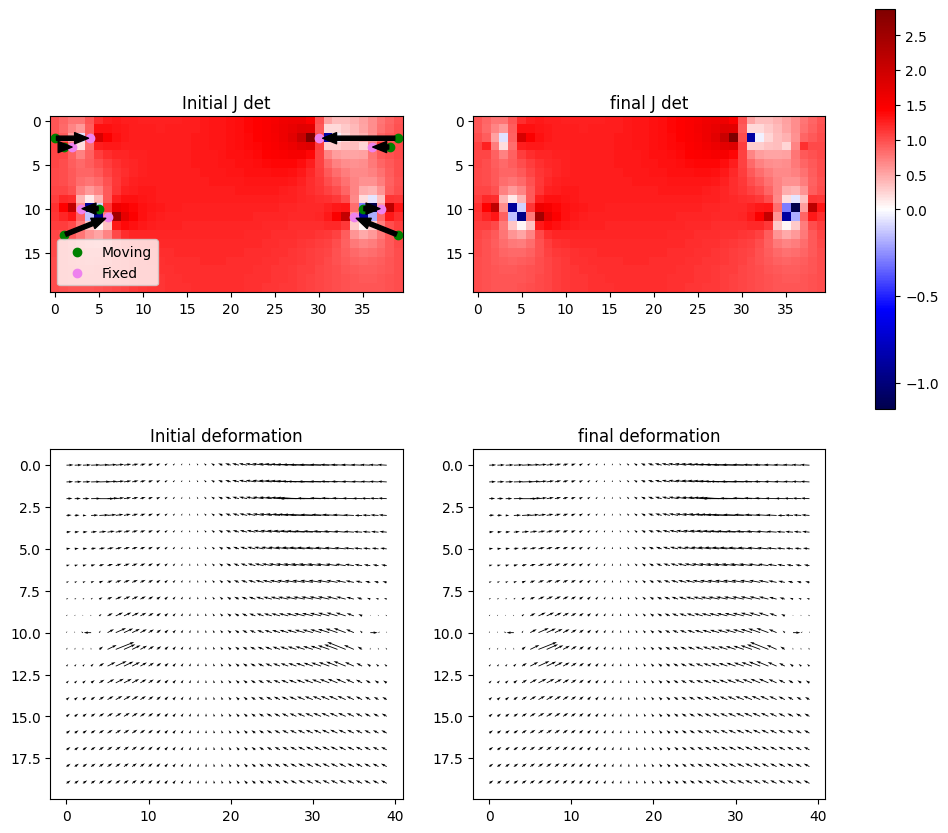

In [276]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
    [0, 10, 5],
    [0, 13, 1],
    [0, 2, 39],
    [0, 3, 38],
    [0, 10, 35],
    [0, 13, 39],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
    [0, 10, 3],
    [0, 11, 6],
    [0, 2, 30],
    [0, 3, 36],
    [0, 10, 37],
    [0, 11, 34]
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [611, 629, 612, 628, 571, 589, 651, 669, 652, 668, 572, 588, 613, 627, 653, 667, 573, 587, 614, 626, 654, 666, 693, 574, 586, 707, 692, 708, 694, 706, 655, 615, 665, 625, 548, 532, 695, 705, 547, 533, 575, 585, 734, 656, 664, 735, 696, 745, 704, 746, 616, 736, 744, 624, 775, 785, 733, 776, 784, 737, 697, 777, 703, 743, 778, 546, 783, 779, 747, 534, 780, 738, 657, 774, 781, 782, 739, 663, 742, 740, 741, 698, 786, 702, 699, 700, 701, 658, 617, 584, 576, 623, 662, 659, 661, 660, 618, 545, 622, 535, 773, 619, 621, 620, 787, 577, 583, 709, 549, 691, 578, 531, 582, 732, 748, 544, 579, 536, 580, 581, 543, 537, 538, 542, 506, 539, 540, 541, 494, 507, 493, 505, 495, 504, 496, 788, 772, 503, 497, 499, 502, 500, 498, 501, 508, 492, 461, 462, 460, 463, 464, 459, 465, 458, 456, 457, 455, 466]
Iter 1: Analysing index 611: Original coord: (11, 15, 0), nearest: (11, 15, 

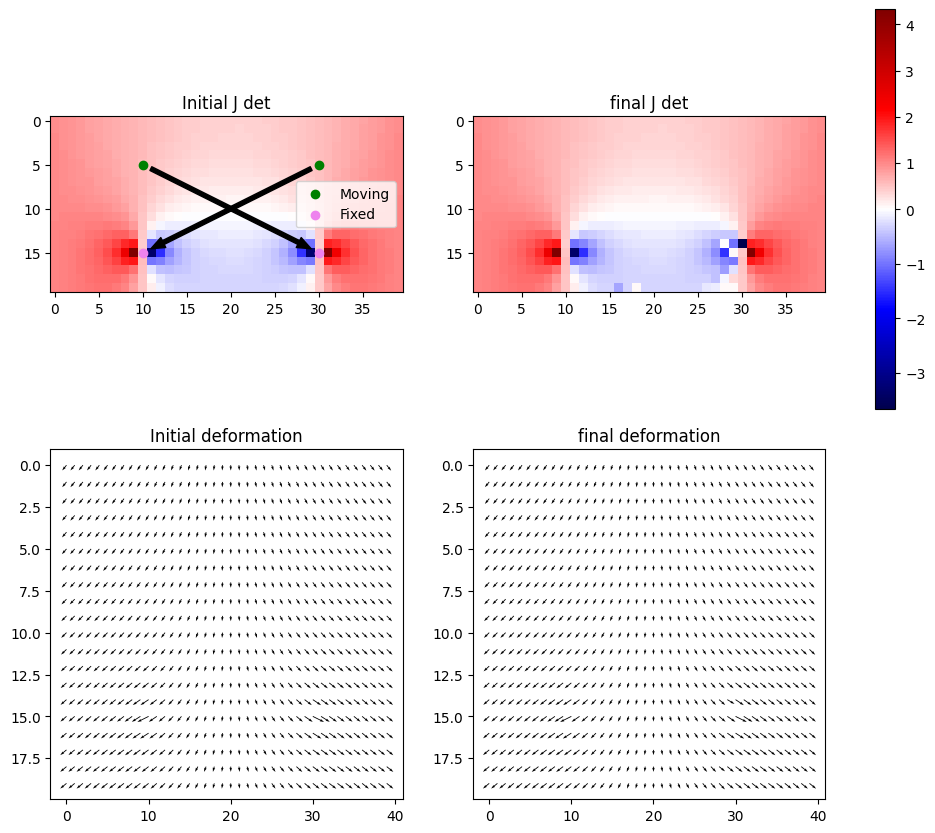

In [277]:
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

# 600 iterations
# 83min - final size 9x9

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [270, 590, 310, 550, 269, 589, 591, 271, 309, 549, 311, 350, 551, 510, 351, 349, 511, 509, 390, 470, 430, 391, 471, 389, 469, 431, 429, 308]
Iter 1: Analysing index 270: Original coord: (30, 6, 0), nearest: (30, 6, 0), jdet: -2.0283188430316623
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1302033435905976
            Iterations: 18
            Function evaluations: 1024
            Gradient evaluations: 18
Optimisation for index 270 completed in 0.13704442977905273s
OP result error for index 270: 0.1302033435905976
Iter 1 end: 28 -ve jacs now at [270 590 310 550 269 589 591 271 309 549 311 350 551 510 351 349 511 509 390 470 430 391 471 389 469 431 429 308] : SITK: [-2.0283187  -1.98807756 -0.75504183 -0.73464807 -0.46306918 -0.45220915 -0.36195465 -0.35513167 -0.34706475 -0.33436918 -0.32340067 -0.31906223 -

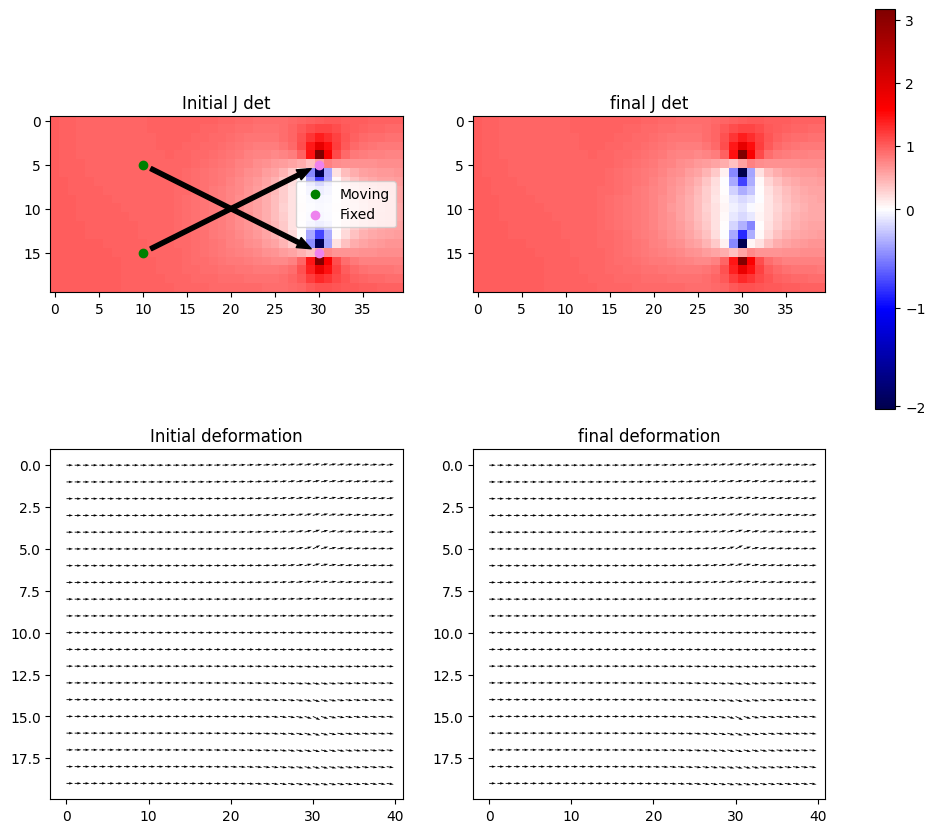

In [278]:
msample = np.array([
    [0, 5, 10],
    [0, 15, 10],
])
fsample = np.array([
    [0, 15, 30],
    [0, 5, 30],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

In [ ]:
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

# not all iterations take the same time?
# Iter 1 Optimisation for index 611 completed in 0.7802479267120361s
# Iter 635 Optimisation for index 693 completed in 278.3064708709717s
# Iter 573 Optimisation for index 494 completed in 63.11005783081055s
# total time 175m - unfinished

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [611, 629, 612, 628, 571, 589, 651, 669, 652, 668, 572, 588, 613, 627, 653, 667, 573, 587, 614, 626, 654, 666, 693, 574, 586, 707, 692, 708, 694, 706, 655, 615, 665, 625, 548, 532, 695, 705, 547, 533, 575, 585, 734, 656, 664, 735, 696, 745, 704, 746, 616, 736, 744, 624, 775, 785, 733, 776, 784, 737, 697, 777, 703, 743, 778, 546, 783, 779, 747, 534, 780, 738, 657, 774, 781, 782, 739, 663, 742, 740, 741, 698, 786, 702, 699, 700, 701, 658, 617, 584, 576, 623, 662, 659, 661, 660, 618, 545, 622, 535, 773, 619, 621, 620, 787, 577, 583, 709, 549, 691, 578, 531, 582, 732, 748, 544, 579, 536, 580, 581, 543, 537, 538, 542, 506, 539, 540, 541, 494, 507, 493, 505, 495, 504, 496, 788, 772, 503, 497, 499, 502, 500, 498, 501, 508, 492, 461, 462, 460, 463, 464, 459, 465, 458, 456, 457, 455, 466]
Iter 1: Analysing index 611: Original coord: (11, 15, 0), nearest: (11, 15, 

In [ ]:
msample = np.array([
    [0, 2, 10],
    [0, 3, 5],
    [0, 6, 4],
    [0, 11, 5],
    [0, 15, 7],
    [0, 19, 12],
    [0, 15, 15],
    [0, 13, 22],
    [0, 19, 22],
    [0, 19, 27],
    [0, 15, 30],
    [0, 12, 33],
    [0, 10, 38],
    [0, 4, 37],
    [0, 6, 30],
    [0, 1, 33],
    [0, 5, 26],
    [0, 2, 23],
    [0, 1, 19],
    [0, 2, 14],
])
fsample = np.array([
    [0, 1, 7],
    [0, 5, 11],
    [0, 6, 1],
    [0, 15, 1],
    [0, 12, 2],
    [0, 16, 14],
    [0, 18, 17],
    [0, 15, 20],
    [0, 16, 24],
    [0, 19, 27],
    [0, 18, 34],
    [0, 17, 40],
    [0, 10, 35],
    [0, 6, 35],
    [0, 2, 34],
    [0, 3, 30],
    [0, 2, 26],
    [0, 2, 23],
    [0, 3, 20],
    [0, 2, 14],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

## Testcases

In [ ]:
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols

run_lapl_and_correction(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish

In [ ]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#run_lapl_and_correction(fixed_sample, msample, fsample)
deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f'deformation shape: {deformation_i.shape}')
print(deformation_i)
phi_corrected, jacobians = iterative_with_jacobians(deformation_i, methodName='SLSQP')
plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
print(jacobian_det2D(deformation_i[1:]))

In [ ]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

In [ ]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

In [ ]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, new_mpoints[:5], new_fpoints[:5])
run_lapl_and_correction(fixed_sample, new_mpoints, new_fpoints)

## Real slice

In [ ]:
# # data analysis

# # Create sample set of points
# mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
# fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

# mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
# #print(mpoints.shape, fpoints.shape) 

# deformation_field_path = "../data/base_unique_correspondences/registered_output/deformation3d.npy"
# deformation_field = np.load(deformation_field_path)

# # select a slice
# def_shape = deformation_field.shape
# print(def_shape)
# deformation_i = deformation_field[:, 349].reshape((def_shape[0], 1, def_shape[2], def_shape[3]))
# print(deformation_i.shape)
# # z values in mpoints, fpoints are for 3 slices numbered 0,1,2
# slice_no = 0

# # use 
# mask = mpoints[:,0]==slice_no
# new_mpoints = mpoints[mask].copy()
# new_mpoints[:,0] = 0

# mask = fpoints[:,0]==slice_no
# new_fpoints = fpoints[mask].copy()
# new_fpoints[:,0] = 0

# print(new_mpoints.shape, new_fpoints.shape)

# phi_corrected, jacobians = iterative_with_jacobians(deformation_i)
# plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
# plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
# # kept running for 450min

## Jdet function testing

In [ ]:
# global val list
print(list_dev)
print('===')
print(num_neg_jac)
print('=====')
print(time_taken)

# L2
list_dev_L2 = [2.680895253076589, 69.80633869969029, 9.418067274643581, 69.80633869969029, 5.197075330527052, 1.8231005476373714, 2.2589086079637837, 2.8612431766103588, 0.0, 27.945036523729176]

num_neg_jac_init_L2 = [12, 158, 28, 158, 29, 5, 3, 2, 0, 129]

num_neg_jac_L2 = [0, 132, 15, 132, 0, 0, 0, 0, 0, 115]

# L2s
list_dev_L2s = [4.768607942055218, 26.252278493509536, 10026.7948106916, 26.252278493509536, 9.104921565888146, 2.379737612461383, 3.019209538644817, 3.1687868005130904, 0.0, 25.14703328621248]

num_neg_jac_L2s = [0, 137, 15, 137, 0, 0, 0, 0, 0, 109]

# L1

list_dev_L1 = [3.1452826411439276, 49.78213374285741, 12.373348412316172, 49.78213374285741, 12.224721045040889, 2.2478387386726184, 2.419587408528433, 3.1974909624498786, 0.0, 22.553299646732658]

num_neg_jac_L1 = [0, 135, 7, 135, 2, 0, 0, 0, 0, 106]

# L1s
list_dev_L1s = [3.8200316274887136, 27.98726389799386, 11.400909181236925, 27.98726389799386, 7.421816327869949, 2.3274873804728444, 2.952056050877296, 3.112671741644684, 0.0, 21.352944007229933]

num_neg_jac_L1s = [0, 132, 11, 132, 0, 0, 0, 0, 0, 110]

#L2wr
list_dev_L2wr = [1.3388562022484387e-06, 2.1911745978666906, 0.5583311141489217, 2.1911745978666906, 0.00010905921377629281, 8.880030350916757e-08, 8.065887478278329e-07, 8.93188013674346e-08, 0.0, 1.4515563532878142]

num_neg_jac_L2wr = [12, 156, 27, 156, 29, 5, 3, 2, 0, 125]

#L1wr - this
list_dev_L1wr = [1.8719204800182033e-05, 2.800815958456984, 0.6335240860765275, 2.800815958456984, 0.01548376720517454, 3.821057987703311e-05, 2.2714245365299625e-05, 3.223513937255436e-05, 0.0, 2.2229220010626967]

num_neg_jac_L1wr = [12, 156, 29, 156, 29, 5, 3, 2, 0, 123]

#L2swr
list_dev_L2swr = [6.347496024011014, 6.0603622126465195, 8.073554663868867, 6.0603622126465195, 9.805082662138908, 2.4315062468207964, 3.329061274139249, 1.7311478095318673, 0.0, 19.893147478504304]

num_neg_jac_L2swr = [0, 162, 30, 162, 6, 0, 0, 0, 0, 127]
tt_L2swr = [[1.0550048351287842, 15.897326946258545, 5.623910903930664, 16.062530040740967, 12.120941877365112, 0.3773469924926758, 0.3408081531524658, 0.3339860439300537, 0.15784001350402832, 8.772908926010132]
]
ttt_L2swr = 71.68918776512146

#L1swr
list_dev_L1swr = [3.300356140988371, 5.219200883030088, 3.8569020877225846, 5.219200883030088, 4.37866602840255, 1.4021137590566208, 2.0081703705493297, 1.228014013747989, 0.0, 11.192059918711248]

num_neg_jac_L1swr = [11, 156, 28, 156, 19, 4, 3, 0, 0, 121]
tt_L1swr = [38.703429222106934, 85.19641089439392, 57.048078775405884, 85.34915089607239, 37.369688749313354, 21.995036840438843, 18.338409185409546, 3.49845290184021, 0.16025185585021973, 81.12396311759949]

ttt_L1swr = 437.7158851623535

full_end = time.time()
print("time taken is", full_end-full_start)